In [ ]:
!pip install dtaidistance
!pip install PyWavelets
!pip install pyentrp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.0 MB/s eta 0:00:00


<ipython-input-2-67f2a8c2401d>:75: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df2.iloc[:, 1:] = df2.iloc[:, 1:].astype(float).fillna(method='ffill').fillna(method='bfill')


Total rows with NaN values: 0
Total NaN values in the DataFrame: 0
Shape after removing NaNs: (2520, 1188)


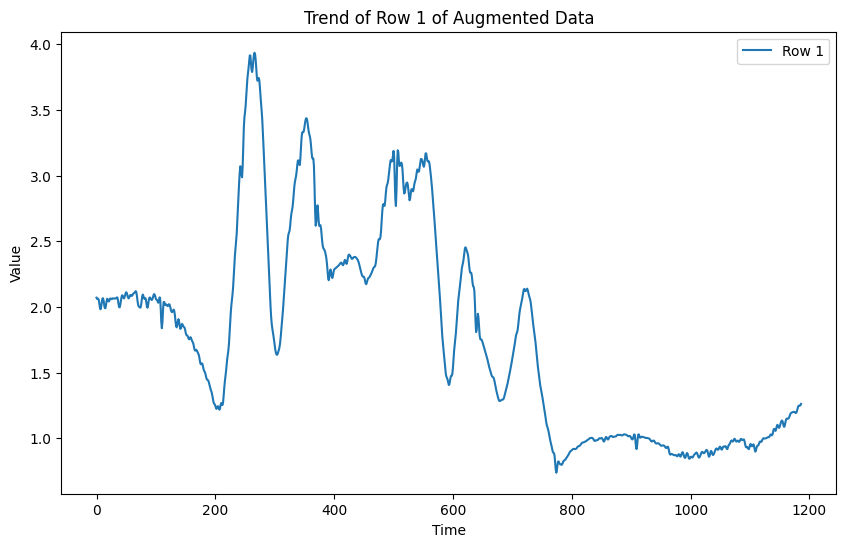

Final dataset shape: (2520, 1188)


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import CubicSpline
import glob
import seaborn as sns

class CSIAugmenter:
    def __init__(self, random_seed=42):
        self.rng = np.random.default_rng(random_seed)

    def jitter(self, data, sigma=0.02):
        """Add Gaussian noise to CSI features"""
        return data + self.rng.normal(0, sigma, data.shape)

    def scale(self, data, factor_range=(0.8, 1.2)):
        """Randomly scale CSI magnitude"""
        factor = self.rng.uniform(factor_range[0], factor_range[1])
        return data * factor

    def slice_shuffle(self, data, window_size=100):
        """Slice and shuffle CSI segments"""
        data_len = len(data)
        slices = [data[i:i+window_size] for i in range(0, data_len, window_size)]
        self.rng.shuffle(slices)
        shuffled = np.concatenate(slices)
        if len(shuffled) < data_len:
            shuffled = np.pad(shuffled, (0, data_len - len(shuffled)), mode='wrap')
        return shuffled[:data_len]

    def magnitude_warp(self, data, sigma=0.1, n_knots=4):
        """Warp CSI magnitude profile using cubic splines"""
        try:
            x = np.linspace(0, len(data)-1, n_knots+2)[1:-1]
            y = self.rng.normal(1.0, sigma, n_knots)
            cs = CubicSpline(x, y)
            warped = data * cs(np.arange(len(data)))
            if np.any(np.isnan(warped)):
                return data
            return warped
        except Exception:
            return data

def butterworth_filter(data, cutoff=20, fs=100, order=5, btype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return filtfilt(b, a, data)


df2 = pd.DataFrame()


csv_files = glob.glob(os.path.join('*.csv'))
for file_path in csv_files:
  df = pd.read_csv(file_path, header=None)
  column_names = [f'Column{i}' for i in range(1, df.shape[1] + 1)]
  df.columns = column_names
  column_averages = df.iloc[:, 1:].mean()
  first_column_mode = df.iloc[:, 0].mode().iloc[0]
  df_result = pd.DataFrame(columns=column_names)
  df_result.loc[0] = [first_column_mode] + column_averages.tolist()
  df2 = pd.concat([df2, df_result], ignore_index=True)
df2.reset_index(drop=True, inplace=True)

df2 = df2.dropna(axis=1)

df2.iloc[:, 1:] = df2.iloc[:, 1:].astype(float).fillna(method='ffill').fillna(method='bfill')

for i in range(len(df2)):
    raw_signal = df2.iloc[i, 1:].values.astype(float)
    filtered_signal = butterworth_filter(raw_signal)
    df2.iloc[i, 1:] = filtered_signal


augmenter = CSIAugmenter()
num_original_samples = len(df2)
augmentation_factor = 5

augmented_samples_list = []
for _ in range(augmentation_factor):
    augmented_samples = []

    for idx in range(num_original_samples):
        original_features = df2.iloc[idx, 1:].values.astype(float)

        for method in ['jitter', 'scale', 'slice_shuffle', 'magnitude_warp']:
            if method == 'jitter':
                augmented_features = augmenter.jitter(original_features)
            elif method == 'scale':
                augmented_features = augmenter.scale(original_features)
            elif method == 'slice_shuffle':
                augmented_features = augmenter.slice_shuffle(original_features)
            else:
                augmented_features = augmenter.magnitude_warp(original_features)

            new_sample = [df2.iloc[idx, 0]] + augmented_features.tolist()
            augmented_samples_list.append(new_sample)

    augmented_samples_list.extend(augmented_samples)


augmented_df = pd.DataFrame(augmented_samples_list, columns=df2.columns)
df2_augmented_combined = pd.concat([df2, augmented_df], ignore_index=True)

nan_counts_per_row = df2_augmented_combined.isna().sum(axis=1)
total_nan_rows_counted = (nan_counts_per_row > 0).sum()

print(f"Total rows with NaN values: {total_nan_rows_counted}")
print(f"Total NaN values in the DataFrame: {nan_counts_per_row.sum()}")


df2_augmented_combined_cleaned = df2_augmented_combined.dropna()
print(f"Shape after removing NaNs: {df2_augmented_combined_cleaned.shape}")


row1_cleaned_data = df2_augmented_combined_cleaned.iloc[0, 1:].astype(float)
plt.figure(figsize=(10, 6))
plt.plot(row1_cleaned_data.values.flatten(), label='Row 1')
plt.title('Trend of Row 1 of Augmented Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print("Final dataset shape:", df2_augmented_combined_cleaned.shape)

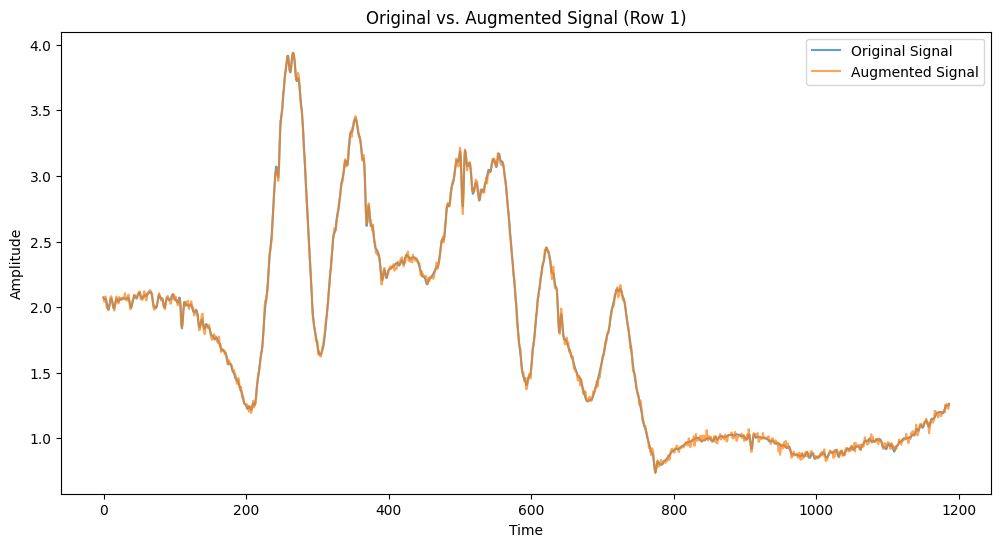

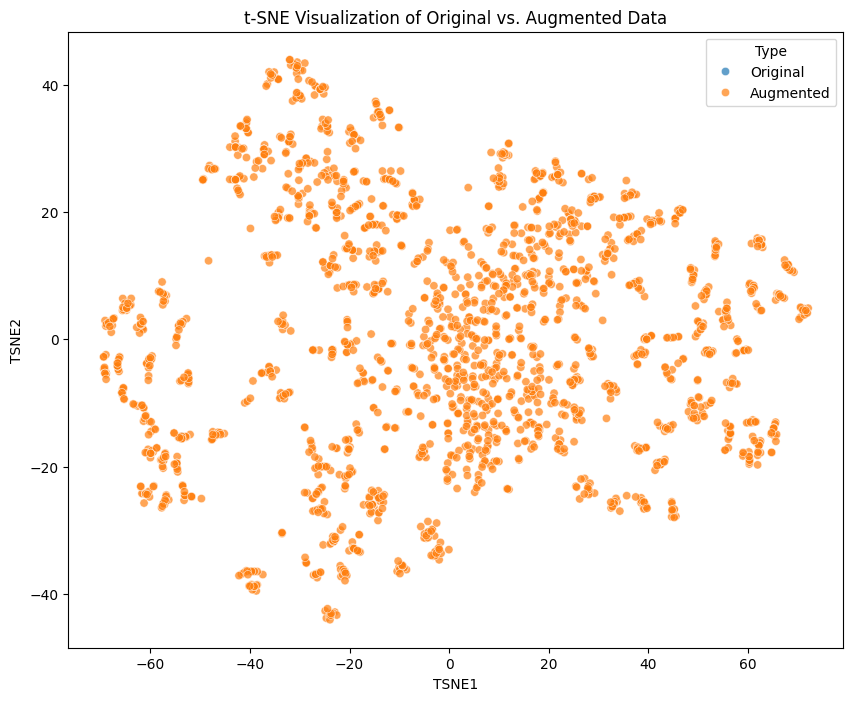

Total rows with NaN values: 0
Total NaN values in the DataFrame: 0
Shape after removing NaNs: (2520, 1188)
Final dataset shape: (2520, 1188)


In [ ]:

num_to_plot = 1

for i in range(num_to_plot):
    original_signal = df2.iloc[i, 1:].astype(float).values
    augmented_signal = augmented_df.iloc[i, 1:].astype(float).values

    plt.figure(figsize=(12, 6))
    plt.plot(original_signal, label='Original Signal', alpha=0.7)
    plt.plot(augmented_signal, label='Augmented Signal', alpha=0.7)
    plt.title(f'Original vs. Augmented Signal (Row {i+1})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

combined_data = np.concatenate([df2.iloc[:, 1:].values, augmented_df.iloc[:, 1:].values])
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_data)


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_scaled)
tsne_df = pd.DataFrame({
    'TSNE1': tsne_result[:, 0],
    'TSNE2': tsne_result[:, 1],
    'Type': ['Original'] * len(df2) + ['Augmented'] * len(augmented_df)
})


plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Type', data=tsne_df, alpha=0.7)
plt.title('t-SNE Visualization of Original vs. Augmented Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()


nan_counts_per_row = df2_augmented_combined.isna().sum(axis=1)
total_nan_rows_counted = (nan_counts_per_row > 0).sum()

print(f"Total rows with NaN values: {total_nan_rows_counted}")
print(f"Total NaN values in the DataFrame: {nan_counts_per_row.sum()}")

df2_augmented_combined_cleaned = df2_augmented_combined.dropna()
print(f"Shape after removing NaNs: {df2_augmented_combined_cleaned.shape}")

print("Final dataset shape:", df2_augmented_combined_cleaned.shape)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, kurtosis, skew, iqr
from sklearn.feature_selection import mutual_info_regression
from scipy.fft import fft
from scipy.signal import find_peaks
from pyentrp import entropy as ent


df_features = pd.DataFrame()


for index, row in df2_augmented_combined_cleaned.iterrows():
    label = row.iloc[0]
    row_data = pd.to_numeric(row.iloc[1:], errors='coerce')


    mean_val = np.mean(row_data)
    median_val = np.nanmedian(row_data)
    std_dev = np.std(row_data)
    min_val = np.min(row_data)
    max_val = np.max(row_data)
    kurtosis_val = row_data.kurtosis()
    skewness_val = row_data.skew()
    mean_abs_diff = np.mean(np.abs(np.diff(row_data)))
    mean_diff = np.mean(np.diff(row_data))
    median_abs_diff = np.median(np.abs(np.diff(row_data)))
    median_diff = np.median(np.diff(row_data))
    sum_abs_diff = np.sum(np.abs(np.diff(row_data)))
    iqr_val = iqr(row_data)
    mean_abs_deviation = np.mean(np.abs(row_data - np.mean(row_data)))
    median_abs_deviation = np.median(np.abs(row_data - np.median(row_data)))
    root_mean_square = np.sqrt(np.mean(np.square(row_data)))
    variance_val = np.var(row_data)

    n = len(row_data)
    next_power_of_two = 2 ** int(np.ceil(np.log2(n)))
    padded_row_data = np.pad(row_data, (0, next_power_of_two - n))

    fft_result = fft(padded_row_data)
    magnitude_spectrum = np.abs(fft_result)
    frequency = np.fft.fftfreq(len(padded_row_data))
    dominant_frequency = np.abs(frequency[np.argmax(magnitude_spectrum)])
    fft_mean_coefficient = np.mean(np.abs(fft_result))
    power_bandwidth = np.trapz(magnitude_spectrum, frequency)
    spectral_centroid = np.dot(np.abs(frequency), magnitude_spectrum) / np.sum(magnitude_spectrum)
    spectral_distance = np.sum(np.abs(np.diff(magnitude_spectrum)))
    spectral_entropy = -np.sum(np.abs(magnitude_spectrum) * np.log2(np.abs(magnitude_spectrum)))
    spectral_kurtosis = kurtosis(magnitude_spectrum)
    spectral_skewness = skew(magnitude_spectrum)
    spectral_slope = np.polyfit(frequency, magnitude_spectrum, 1)[0]
    spectral_variation = np.std(magnitude_spectrum) / np.mean(magnitude_spectrum)
    wavelet_energy = np.sum(np.square(np.abs(row_data)))

    permutation_entropy = ent.permutation_entropy(row_data)
    weighted_permutation_entropy = ent.weighted_permutation_entropy(row_data)
    absolute_energy = np.sum(np.square(row_data))
    average_power = np.mean(np.square(row_data))


    sorted_data = np.sort(row_data)
    ecdf = np.searchsorted(sorted_data, row_data, side='left') / len(row_data)
    ecdf_percentile = np.percentile(row_data, 25)


    peaks, _ = find_peaks(row_data)
    peak_to_peak_distance = np.diff(peaks).mean() if len(peaks) > 1 else np.nan
    autocorrelation = np.correlate(row_data, row_data, mode='full')
    area_under_curve = np.trapz(row_data)


    feature_values = [
        label, mean_val, median_val, std_dev, min_val, max_val,
        kurtosis_val, skewness_val, mean_abs_diff, mean_diff, median_abs_diff,
        median_diff, sum_abs_diff, iqr_val, mean_abs_deviation,
        median_abs_deviation, root_mean_square, variance_val,
        permutation_entropy, weighted_permutation_entropy, absolute_energy,
        average_power, ecdf_percentile, peak_to_peak_distance,
        area_under_curve, fft_mean_coefficient, power_bandwidth, spectral_centroid,
        spectral_distance, spectral_entropy, spectral_kurtosis,
        spectral_skewness, spectral_slope, spectral_variation, wavelet_energy]

    df_result = pd.DataFrame(
        [feature_values],
        columns=[
            "Label", "Mean", "Median", "Std Dev", "Min", "Max",
            "Kurtosis", "Skewness", "Mean Abs Diff", "Mean Diff", "Median Abs Diff",
            "Median Diff", "Sum Abs Diff", "IQR", "Mean Abs Deviation",
            "Median Abs Deviation", "Root Mean Square", "Variance",
            "Permutation Entropy", "Weighted Permutation Entropy", "Absolute Energy",
            "Average Power", "ECDF Percentile",
            "Peak to Peak Distance", "Area Under Curve", "FFT Mean Coefficient",
            "Power Bandwidth", "Spectral Centroid", "Spectral Distance",
            "Spectral Entropy", "Spectral Kurtosis", "Spectral Skewness",
            "Spectral Slope", "Spectral Variation", "Wavelet Energy"]
    )

    df_features = pd.concat([df_features, df_result], ignore_index=True)

df_features

,Label,Mean,Median,Std Dev,Min,Max,Kurtosis,Skewness,Mean Abs Diff,Mean Diff,...,FFT Mean Coefficient,Power Bandwidth,Spectral Centroid,Spectral Distance,Spectral Entropy,Spectral Kurtosis,Spectral Skewness,Spectral Slope,Spectral Variation,Wavelet Energy
0,3Subject2Stand1Sitting,1.775541,1.729440,0.787479,0.737118,3.936126,-0.546939,0.607275,0.020989,-0.000682,...,8.535134,6.574399,0.052448,9245.493091,-112861.099040,641.525205,23.587121,0.020107,7.776388,4478.158717
1,3Subject2Stand1Sitting,1.820203,1.504024,0.706102,0.636884,3.446354,-0.792575,0.677338,0.019226,0.000021,...,7.554302,5.891475,0.045470,9253.941982,-103939.145019,649.047730,23.581201,0.018244,8.847796,4524.508657
2,3Subject2Stand1Sitting,1.645375,1.285390,0.932195,0.461410,3.853495,-0.937260,0.638498,0.018863,-0.000619,...,7.031844,5.538807,0.040964,7025.511136,-98163.459829,580.904252,22.702076,0.017819,9.211399,4245.004122
3,2Subject2Stand1Sitting,1.485472,1.442862,0.947620,0.023074,3.369475,-1.351634,0.148007,0.017888,-0.002143,...,8.980461,6.813513,0.060274,6942.677440,-113527.132870,504.247556,20.609543,0.021680,6.685368,3685.172344
4,2Subject2Stand1Sitting,1.512489,1.021658,1.074217,0.131689,3.558898,-1.466805,0.464088,0.018414,-0.002014,...,9.417187,7.146827,0.061399,7823.289907,-120702.161799,452.246107,19.543011,0.022275,6.712993,4085.137476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2Subject2Stand1Sitting,1.499740,1.453123,0.691751,0.072731,3.188858,-0.312661,0.335524,0.019428,0.001754,...,9.400557,7.126015,0.065669,9646.076182,-115154.081517,547.368446,20.549238,0.021317,5.969860,3237.825567
2516,3Subject2Stand1Sitting,1.755073,1.431219,0.744522,0.737679,3.762594,-0.430102,0.949607,0.029903,-0.000163,...,7.371510,5.904053,0.045299,7686.541071,-101637.216704,637.755502,23.465832,0.019703,8.854102,4314.263499
2517,3Subject2Stand1Sitting,1.981769,1.620839,0.840201,0.838251,4.264511,-0.423036,0.952336,0.020162,-0.000187,...,8.179990,6.477714,0.040040,8566.058590,-117198.742226,637.526882,23.459730,0.020354,9.010769,5499.782681
2518,3Subject2Stand1Sitting,1.755037,1.435401,0.744074,0.742348,3.776613,-0.423036,0.952336,0.022967,0.000502,...,9.626124,8.159705,0.060263,10813.033227,-124068.385240,613.053738,22.437294,0.027715,6.748990,4313.323777


In [ ]:

df_features['Label'] = '3_Subjects_2_Standing_1_Sitting'

output_features_csv_path = r'3_Subjects_2_Standing_1_Sitting.csv'

df_features.to_csv(output_features_csv_path, index=False)
print(f'Features DataFrame successfully written to: {output_features_csv_path}')

Features DataFrame successfully written to: 3_Subjects_2_Standing_1_Sitting.csv


In [ ]:
df_features

,Label,Mean,Median,Std Dev,Min,Max,Kurtosis,Skewness,Mean Abs Diff,Mean Diff,...,FFT Mean Coefficient,Power Bandwidth,Spectral Centroid,Spectral Distance,Spectral Entropy,Spectral Kurtosis,Spectral Skewness,Spectral Slope,Spectral Variation,Wavelet Energy
0,3_Subjects_2_Standing_1_Sitting,1.775541,1.729440,0.787479,0.737118,3.936126,-0.546939,0.607275,0.020989,-0.000682,...,8.535134,6.574399,0.052448,9245.493091,-112861.099040,641.525205,23.587121,0.020107,7.776388,4478.158717
1,3_Subjects_2_Standing_1_Sitting,1.820203,1.504024,0.706102,0.636884,3.446354,-0.792575,0.677338,0.019226,0.000021,...,7.554302,5.891475,0.045470,9253.941982,-103939.145019,649.047730,23.581201,0.018244,8.847796,4524.508657
2,3_Subjects_2_Standing_1_Sitting,1.645375,1.285390,0.932195,0.461410,3.853495,-0.937260,0.638498,0.018863,-0.000619,...,7.031844,5.538807,0.040964,7025.511136,-98163.459829,580.904252,22.702076,0.017819,9.211399,4245.004122
3,3_Subjects_2_Standing_1_Sitting,1.485472,1.442862,0.947620,0.023074,3.369475,-1.351634,0.148007,0.017888,-0.002143,...,8.980461,6.813513,0.060274,6942.677440,-113527.132870,504.247556,20.609543,0.021680,6.685368,3685.172344
4,3_Subjects_2_Standing_1_Sitting,1.512489,1.021658,1.074217,0.131689,3.558898,-1.466805,0.464088,0.018414,-0.002014,...,9.417187,7.146827,0.061399,7823.289907,-120702.161799,452.246107,19.543011,0.022275,6.712993,4085.137476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,3_Subjects_2_Standing_1_Sitting,1.499740,1.453123,0.691751,0.072731,3.188858,-0.312661,0.335524,0.019428,0.001754,...,9.400557,7.126015,0.065669,9646.076182,-115154.081517,547.368446,20.549238,0.021317,5.969860,3237.825567
2516,3_Subjects_2_Standing_1_Sitting,1.755073,1.431219,0.744522,0.737679,3.762594,-0.430102,0.949607,0.029903,-0.000163,...,7.371510,5.904053,0.045299,7686.541071,-101637.216704,637.755502,23.465832,0.019703,8.854102,4314.263499
2517,3_Subjects_2_Standing_1_Sitting,1.981769,1.620839,0.840201,0.838251,4.264511,-0.423036,0.952336,0.020162,-0.000187,...,8.179990,6.477714,0.040040,8566.058590,-117198.742226,637.526882,23.459730,0.020354,9.010769,5499.782681
2518,3_Subjects_2_Standing_1_Sitting,1.755037,1.435401,0.744074,0.742348,3.776613,-0.423036,0.952336,0.022967,0.000502,...,9.626124,8.159705,0.060263,10813.033227,-124068.385240,613.053738,22.437294,0.027715,6.748990,4313.323777
